In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [112]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(9, 7, 1, obs_act, 'Obs1')
obs2 = Obstacle(6, 6, 1, obs_act, 'Obs2')
obs3 = Obstacle(7, 9, 1, obs_act, 'Obs3')
# obs4 = Obstacle(4, 4, 1, obs_act, 'Obs4')
# obs5 = Obstacle(6, 7.5, 1, obs_act, 'Obs5')
# obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
# obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
# obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [113]:
# Desired Running and Terminal Model
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 1000, 2000, 2000, 2000])
w_term_possibles = np.array([1000, 1., 1., 1000, 1000, 1000, 500, 0, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  5.10000e+01  5.10000e+01  3.45453e+01  1.0000  0.00000e+00  4.96918e+00
   2  1.19383e+00  1.19383e+00  9.60791e-02  1.0000  1.88738e-14  1.09044e-02
   3  1.19241e+00  1.19241e+00  7.56381e-02  1.0000  1.34823e-10  4.43402e-03
   4  1.19151e+00  1.19151e+00  6.87248e-02  1.0000  1.61335e-10  2.33564e-03
   5  1.19073e+00  1.19073e+00  6.52421e-02  1.0000  1.42109e-10  1.48920e-03
   6  1.19001e+00  1.19001e+00  6.31933e-02  1.0000  1.40743e-10  1.07230e-03
   7  1.18933e+00  1.18933e+00  6.17395e-02  1.0000  1.30351e-10  8.35965e-04
   8  1.18867e+00  1.18867e+00  6.05087e-02  1.0000  1.15181e-10  6.88349e-04
   9  1.18804e+00  1.18804e+00  5.97412e-02  1.0000  1.28949e-10  5.50312e-04
  10  1.18742e+00  1.18742e+00  5.89693e-02  1.0000  1.06910e-10  5.40889e-04
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.18682e+00  1.18682e+00  5.82455e-02  1.0000  1.11150e-10  5.3170

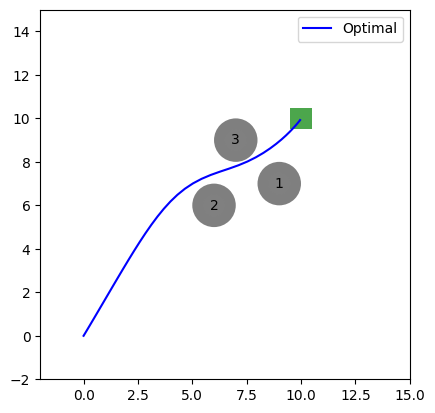

In [114]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [115]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
 END  0.00000e+00  0.00000e+00  0.00000e+00   ----   0.00000e+00  0.00000e+00
True


In [116]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [154]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    factor = 1/10000
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        # o = np.exp(factor*(opt_traj_cost - non_opt_traj_cost)**2)
        # den += np.max([np.nextafter(0,1),o*np.exp(-non_opt_traj_cost)])
        den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_new(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, w_old, Lambda = 0.001):
    factor = 1/1000
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        o = np.exp(factor*(opt_traj_cost - non_opt_traj_cost)**2)
        # den += np.max([np.nextafter(0,1),o*np.exp(-non_opt_traj_cost)])
        den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x - w_old)
    return output

def fcn_w_2D(x, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    den += np.exp(-cost_set.traj_cost(xs_non_optimal, us_non_optimal, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [267]:
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10

w0 = w_bad
w_prev = w0
it = 0
max_set_size = 30
it_max_IRL = max_set_size + 1
# it_max_IRL = 50
it_max_sqp = 5

xs = []
us = []
ws = []
Fcns= []
Cost_Diffs = []
W_Diffs = []
Traj_Diffs = []

xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)

init_choices = ['bad','optimal','previous']
stochastic = False
w_tol = 0.00001
traj_tol = 1e-10
w_diff = 1
traj_diff = 1
e = 1
while traj_diff > traj_tol and it < it_max_IRL:
    
    # With simple regulation: ||w||
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    # # With simple new regulation: ||w - w_old||
    # res = minimize(fcn_w_new, 
    #                w0, 
    #                args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, w_prev, Lambda), 
    #                bounds=bnds, 
    #                method='L-BFGS-B', 
    #                tol = tol,
    #                options=options)
    
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)

    fcn_value = fcn_w(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)
    Fcns.append(fcn_value)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]
    for i in range(T):
        sqp_non_opt.problem.runningModels[i].differential.model.costWeights = w_run
    sqp_non_opt.problem.terminalModel.differential.model.costWeights = w_term
    sqp_non_opt.with_callbacks=False

    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    else:
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy()))

    # # Add a noisy trajectory to the set
    # # scale = 1/traj_diff + 1.0
    # scale = 5.0
    # noisy_u = np.vstack(sqp_non_opt.us.tolist().copy())+np.random.normal(0.0,scale,np.stack(sqp_non_opt.us.tolist()).shape)
    # us.append(noisy_u)
    # xs.append(np.stack(problem.rollout([noisy_u[i] for i in range(T)])))
    
    ws.append(w_loop.copy())
    
    if len(xs_non_optimal_set) <= max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if not stochastic:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
        else:
            xs_non_optimal_set = random.choices(xs, k=max_set_size)
            us_non_optimal_set = random.choices(us, k=max_set_size)
        
    
    opt_diff = (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], dt)- 
                cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], dt))**2
    w_diff = np.linalg.norm(w_loop - w_prev)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2
    Cost_Diffs.append(opt_diff)
    W_Diffs.append(w_diff)
    Traj_Diffs.append(traj_diff)
    if it > 0:
        print('Fcn Value: {:.4f} || Weight Diff: {:.4f} || Traj Diff: {:.4f}, || Optimal Diff: {:.4f}'.format(
            fcn_value, w_diff, traj_diff, opt_diff
        ))
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()

    # # Initial W for IRL as initial bad weights
    # w0 = w_bad
    
    w_prev = w0
    it += 1

print(res)
w_irl = res.x/np.max(res.x)

Fcn Value: 0.0000 || Weight Diff: 0.3254 || Traj Diff: 3480.7653, || Optimal Diff: 24.5186
Fcn Value: 0.0180 || Weight Diff: 0.7441 || Traj Diff: 8.2929, || Optimal Diff: 0.1123
Fcn Value: 0.5771 || Weight Diff: 0.1763 || Traj Diff: 0.0032, || Optimal Diff: 0.0228
Fcn Value: 1.0293 || Weight Diff: 0.0555 || Traj Diff: 0.3982, || Optimal Diff: 0.0840
Fcn Value: 1.4889 || Weight Diff: 0.0024 || Traj Diff: 0.3032, || Optimal Diff: 0.0444
Fcn Value: 1.4842 || Weight Diff: 0.1902 || Traj Diff: 0.0136, || Optimal Diff: 0.0159
Fcn Value: 1.6505 || Weight Diff: 0.2806 || Traj Diff: 0.0029, || Optimal Diff: 0.0316
Fcn Value: 1.8318 || Weight Diff: 0.0080 || Traj Diff: 0.0036, || Optimal Diff: 0.0376
Fcn Value: 1.9874 || Weight Diff: 0.0014 || Traj Diff: 0.0026, || Optimal Diff: 0.0327
Fcn Value: 2.1220 || Weight Diff: 0.0001 || Traj Diff: 0.0026, || Optimal Diff: 0.0306
Fcn Value: 2.2304 || Weight Diff: 0.0154 || Traj Diff: 0.1742, || Optimal Diff: 1.3496
Fcn Value: 2.2560 || Weight Diff: 0.001

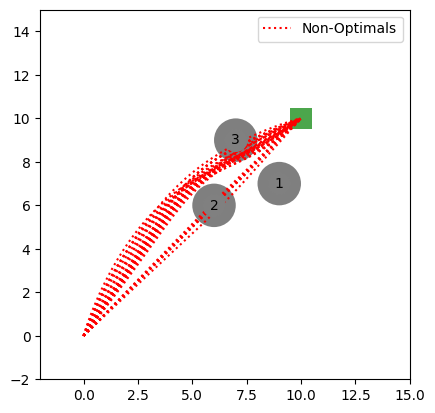

In [268]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [278]:
w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.01424790891020011
Terminal ||  Desired:  0.5 IRL:  1.0

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.0006923193052923748
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  1.0 IRL:  0.04576526872201026
Terminal ||  Desired:  0.5 IRL:  0.003995671236150039

Obs2 :
Running ||  Desired:  1.0 IRL:  0.7652998363071859
Terminal ||  Desired:  0.5 IRL:  0.0

Obs3 :
Running ||  Desired:  1.0 IRL:  0.3375761306919696
Terminal ||  Desired:  0.5 IRL:  0.003995671236150039



In [279]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

Desired:                  3.26948922113105
IRL:                      3.3277718869151203

Desired Trajectory Cost:  1.0141820074355645
with IRL Weight:          2.0404102169660914

IRL Trajectory Cost:      1.9870023902055427
with Desired Weight:      1.0599792201992393


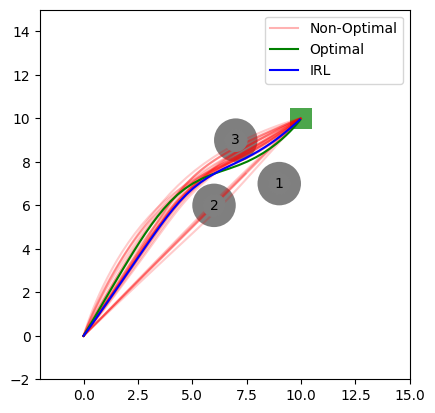

In [280]:
plot_results(xs_optimal, xs[:-1], xs[-1], obs_set, target_high)

In [285]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
x0 = np.array([7.0, 5.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]
# xs_init = [xs_optimal[i] for i in range(T+1)]
# us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.77470e+01  1.77470e+01  3.01631e+01  1.0000  0.00000e+00  5.79422e+00
   2  2.57018e+00  2.57018e+00  1.11469e+01  1.0000  3.64153e-14  1.69182e+00
   3  4.32188e-01  4.32188e-01  7.92674e+00  1.0000  1.80688e-08  1.53189e-02
   4  3.72288e-01  3.72288e-01  1.19866e+00  1.0000  1.71405e-08  1.87581e-03
   5  3.71045e-01  3.71045e-01  2.33570e-02  1.0000  2.00791e-09  2.42084e-05
 END  3.71044e-01  3.71044e-01  1.52939e-04   ----   4.32013e-11  5.02481e-07


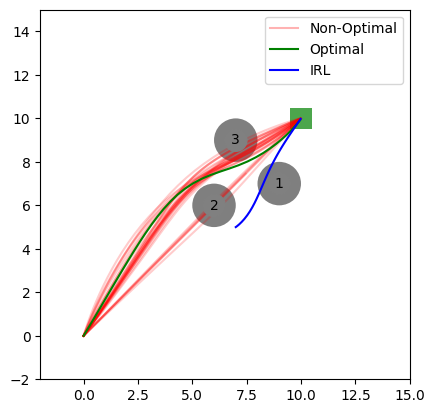

In [286]:
plot_results(xs_optimal, xs[:-1], xs_output, obs_set, target_high)

In [275]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [276]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

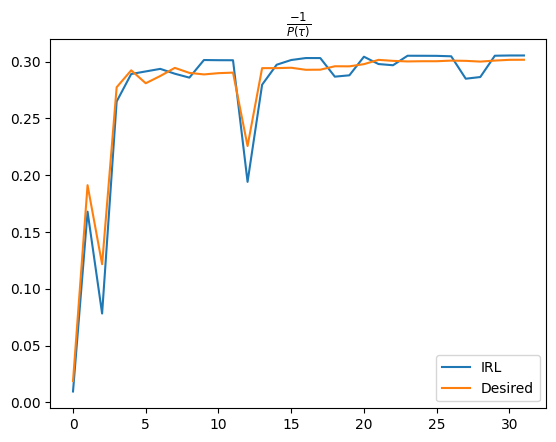

In [277]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()